In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [03:08, 1065.83it/s]


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [6]:
responses[99]

{'author': 'ronnichka',
 'bank_license': 'лицензия № 880',
 'bank_name': 'Югра',
 'city': 'г. Саратов',
 'datetime': '2015-06-03 20:56:57',
 'num_comments': 0,
 'rating_grade': 3,
 'rating_not_checked': False,
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'title': 'Карта ко вкладу'}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

### Посчитайте количество отзывов в разных городах и на разные банки

In [14]:
counter = {}
for resp in responses:
    if resp['city'] in counter:
        counter[resp['city']] += 1
    else:
        counter[resp['city']] = 1

In [15]:
counter

{'г. Москва': 55354,
 'г. Новосибирск': 2300,
 'г. Ставрополь': 696,
 'г. Челябинск': 1507,
 'г. Волгоград': 1014,
 'г. Пермь': 1163,
 'г. Ростов-на-Дону': 1891,
 'г. Воронеж': 1210,
 'г. Таганрог (Ростовская обл.)': 8,
 'г. Санкт-Петербург': 14342,
 'г. Конаково': 9,
 'г. Мурманск': 434,
 'г. Волгодонск (Ростовская обл.)': 7,
 'г. Большеречье': 2,
 'г. Одинцово (Московская обл.)': 8,
 'г. Салават (Республика Башкортостан)': 4,
 'г. Краснодар': 1262,
 'г. Кострома': 160,
 'г. Нижний Новгород': 1976,
 'г. Орел': 234,
 'г. Саратов': 933,
 'г. Казань': 1440,
 'г. Реутов (Московская обл.)': 3,
 'г. Ульяновск': 500,
 'г. Красноярск': 1236,
 'г. Хабаровск': 681,
 'г. Магнитогорск (Челябинская обл.)': 16,
 'г. Фролово (Волгоградская обл.)': 1,
 'г. Новочеркасск': 67,
 'г. Чита': 126,
 'г. таганрог': 8,
 'г. Йошкар-Ола': 190,
 'г. Нижний Тагил': 189,
 'г. Ханты-Мансийск': 48,
 'г. Россия': 204,
 'г. Липецк': 461,
 'г. Нижнекамск (Республика Татарстан)': 5,
 'г. Тюмень': 656,
 'г. Москва, Санкт

In [51]:
counter = {}
for resp in responses:
    if resp['bank_name'] in counter:
        counter[resp['bank_name']] += 1
    else:
        counter[resp['bank_name']] = 1
counter

{'2Т Банк': 655,
 'АБ Финанс': 23,
 'АББ': 2,
 'АМБ Банк': 1,
 'АМТ Банк': 142,
 'АФ Банк': 19,
 'Абсолют Банк': 782,
 'Авангард': 2733,
 'Аверс': 7,
 'Автоградбанк': 2,
 'Автоторгбанк': 2,
 'Агропромкредит': 41,
 'Агророс': 3,
 'Агросоюз': 22,
 'Агрохимбанк': 1,
 'Адамон Банк': 3,
 'Адмиралтейский': 21,
 'Азиатско-Тихоокеанский Банк': 182,
 'Ай-Си-Ай-Си-Ай Банк (ICICI)': 8,
 'АйМаниБанк': 925,
 'Айви Банк': 13,
 'Ак Барс': 184,
 'Академический Русский Банк': 1,
 'Акибанк': 13,
 'Аксонбанк': 2,
 'АктивКапитал Банк': 75,
 'Акцент': 1,
 'Акцепт': 11,
 'Алданзолотобанк': 2,
 'Александровский': 23,
 'Алеф-Банк': 10,
 'Алмазэргиэнбанк': 1,
 'Алтынбанк': 1,
 'Альта-Банк': 5,
 'Альфа-Банк': 10224,
 'Анелик РУ': 5,
 'Анкор Банк': 6,
 'Анталбанк': 19,
 'Арксбанк': 85,
 'Аспект': 1,
 'ББР Банк': 16,
 'БИНБАНК кредитные карты': 1464,
 'БКС — Инвестиционный Банк': 41,
 'БМВ Банк': 8,
 'БНП Париба Банк': 475,
 'БСТ-Банк': 1,
 'БФГ-Кредит': 23,
 'БайкалБанк': 6,
 'БайкалИнвестБанк': 1,
 'Байкалкредо

### Постройте гистограмы длин слов в символах и в словах

In [16]:
df = pd.DataFrame()

lens = []
symbols = []
texts = []
for resp in responses:
    symbols.append(len(resp['text']))
    lens.append(len(resp['text'].split(' ')))
    texts.append(resp['text'])

grades = []
for resp in responses:
    grades.append(resp['rating_grade'])

df['lens'] = lens
df['symbols'] = symbols
df['texts'] = texts
df['grades'] = grades

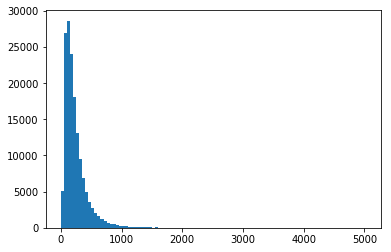

In [25]:
a = plt.hist(df.lens, bins = 100)

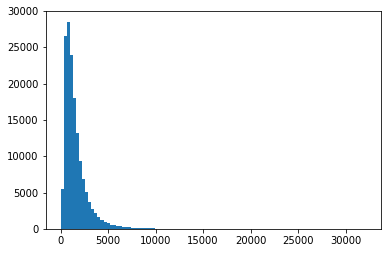

In [26]:
b = plt.hist(df.symbols, bins = 100)

### Найдите 10 самых частых:

#### Слов

In [40]:
import re
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""


df.texts = df.texts.str.lower()
df.texts = df.texts.apply(words_only)

In [42]:
from nltk import FreqDist
n_types = []
n_tokens = []
tokens = []
fd = FreqDist()
for index, row in df.iterrows():
    tokens = row['texts'].split()
    fd.update(tokens)
    n_types.append(len(fd))
    n_tokens.append(sum(fd.values()))
for i in fd.most_common(10):
    print(i)

('в', 1330550)
('и', 1058997)
('не', 855335)
('на', 707935)
('что', 640057)
('я', 577500)
('с', 464037)
('по', 372769)
('мне', 320958)
('банка', 275906)


#### Слов без стоп-слов

In [43]:
from nltk.corpus import stopwords

mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

def lemmatize(text):
    m = MorphAnalyzer()
    try:
        lemmas1 = [m.parse(word)[0].normal_form for word in text.split()]
        return ' '.join(lemmas1) 
    except:
        return " "

mystoplemmas = ['который','прошлый','сей', 'свой', 'наш', 'мочь']
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

In [46]:
df['no_stopw'] = df['texts'].apply(remove_stopwords)

In [48]:
from nltk import FreqDist
n_types = []
n_tokens = []
tokens = []
fd = FreqDist()
for index, row in df.iterrows():
    tokens = row['no_stopw'].split()
    fd.update(tokens)
    n_types.append(len(fd))
    n_tokens.append(sum(fd.values()))
for i in fd.most_common(10):
    print(i)

('банка', 275906)
('банк', 215426)
('деньги', 131201)
('карту', 105829)
('карты', 101821)
('кредит', 81136)
('день', 76552)
('банке', 72169)
('заявление', 70423)
('очень', 66824)


#### Лемм

In [53]:
from pymorphy2 import MorphAnalyzer

In [60]:
from tqdm._tqdm_notebook import tqdm_notebook

tqdm_notebook.pandas('PROGRESS>>>')
df['text_lemmatize'] = df['no_stopw'].progress_apply(lemmatize)

HBox(children=(IntProgress(value=0, max=153499), HTML(value='')))

In [14]:
# df.to_csv('lemmatized.csv')

In [3]:
df = pd.read_csv('lemmatized.csv')

In [13]:
# df['lemm'] = df.no_stopw.apply(lemmatize)

In [59]:
lemm = []
for i in df.no_stopw:
    lemm.append(lemmatize(i))

### Постройте кривые Ципфа и Хипса

In [6]:
df.head()

,Unnamed: 0,lens,symbols,texts,grades,no_stopw,text_lemmatize
0,0,225,1523,добрый день я не являюсь клиентом банка и пору...,NaN,добрый день являюсь клиентом банка поручителем...,добрый день являться клиент банка поручитель к...
1,1,141,1026,доброго дня являюсь держателем зарплатной карт...,NaN,доброго дня являюсь держателем зарплатной карт...,добрый день являться держатель зарплатный карт...
2,2,90,588,здравствуйте дублирую свое заявление от в до м...,NaN,здравствуйте дублирую свое заявление можайский...,здравствовать дублировать свой заявление можай...
3,3,125,740,добрый день я открыл расчетный счет в сбербанк...,NaN,добрый день открыл расчетный счет сбербанке юр...,добрый день открыть расчётный счёт сбербанк юр...
4,4,304,1896,г взяла кредит в вашем банке заявленная мною с...,NaN,г взяла кредит вашем банке заявленная мною сум...,год взять кредит ваш банка заявить я сумма руб...


## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

In [4]:
import gensim

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [17]:
df.drop([153116,145330], inplace=True)

In [6]:
from gensim.corpora import *
texts = [df.text_lemmatize.iloc[i].split() for i in range(len(df))]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [7]:
%%time
from gensim.models import  *
from gensim import similarities

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# index = similarities.MatrixSimilarity(corpus_tfidf)
# sims = index[corpus_tfidf]

Wall time: 9.25 s


In [8]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

Wall time: 5min 9s


In [10]:
lsi.show_topics(30)

[(0,
  '0.193*"карта" + 0.133*"кредит" + 0.114*"деньга" + 0.108*"заявление" + 0.106*"счёт" + 0.100*"банкомат" + 0.100*"вклад" + 0.099*"отделение" + 0.099*"рубль" + 0.096*"сумма"'),
 (1,
  '-0.381*"вклад" + 0.358*"кредит" + -0.216*"банкомат" + -0.173*"карта" + 0.164*"страховка" + 0.147*"задолженность" + 0.143*"платёж" + 0.140*"погашение" + -0.121*"деньга" + 0.117*"звонок"'),
 (2,
  '-0.501*"вклад" + 0.277*"банкомат" + 0.220*"карта" + 0.184*"сбербанк" + 0.133*"заявление" + -0.129*"кредит" + 0.120*"операция" + -0.119*"договор" + 0.117*"деньга" + -0.116*"очередь"'),
 (3,
  '-0.256*"вклад" + -0.227*"рубль" + -0.223*"сумма" + 0.201*"номер" + 0.174*"заявка" + -0.166*"платёж" + -0.164*"погашение" + -0.154*"договор" + 0.153*"звонок" + -0.146*"процент"'),
 (4,
  '0.331*"вклад" + 0.266*"номер" + -0.232*"карта" + -0.222*"страховка" + -0.209*"заявка" + 0.188*"звонок" + -0.154*"кредит" + 0.138*"ваш" + 0.135*"телефон" + -0.114*"одобрить"'),
 (5,
  '0.479*"банкомат" + -0.386*"карта" + 0.161*"купюра" +

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

### Подготовка данных

In [18]:
df2 = df[(df['grades'] == 1) | (df['grades'] == 5)]
Y = df2['grades']
X = df2.drop('grades', axis = 1)
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=777)

for train_index, test_index in splitter.split(X, Y):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    
    Y_train = Y.iloc[train_index]
    Y_test = Y.iloc[test_index]
len(X_train), len(Y_train), len(X_test), len(Y_test)

(49679, 49679, 12420, 12420)

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import *
from sklearn.feature_extraction.text import *
from sklearn.metrics import *

### tf-idf + svd

In [21]:
clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])

clf.fit(X_train['text_lemmatize'], Y_train)
true = Y_test
predictions = clf.predict(X_test['text_lemmatize'])

print("Precision: {0:6.2f}".format(precision_score(true, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(true, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(true, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(true, predictions)))
print(classification_report(true, predictions))

Precision:   0.58
Recall:   0.55
F1-measure:   0.54
Accuracy:   0.74
             precision    recall  f1-score   support

        1.0       0.78      0.91      0.84      9477
        5.0       0.38      0.18      0.25      2943

avg / total       0.69      0.74      0.70     12420



###  LDA

In [22]:
clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('lda', LatentDirichletAllocation()), 
    ('clf', RandomForestClassifier())
])

clf.fit(X_train['text_lemmatize'], Y_train)
predictions = clf.predict(X_test['text_lemmatize'])

print("Precision: {0:6.2f}".format(precision_score(true, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(true, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(true, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(true, predictions)))
print(classification_report(true, predictions))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Precision:   0.88
Recall:   0.83
F1-measure:   0.85
Accuracy:   0.90
             precision    recall  f1-score   support

        1.0       0.91      0.96      0.93      9477
        5.0       0.84      0.70      0.77      2943

avg / total       0.90      0.90      0.89     12420



### С параметрами

In [23]:
clf = Pipeline([
    ('vect', CountVectorizer(analyzer = 'char', ngram_range={2,3})),
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=5, random_state=0)),
    ('tsne', TSNE(n_components=2, perplexity=5, verbose=0)),
    ('clf', RandomForestClassifier()),
])


clf.fit(X_train['text_lemmatize'], Y_train)
predictions = clf.predict(X_test['text_lemmatize'])

print("Precision: {0:6.2f}".format(precision_score(true, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(true, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(true, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(true, predictions)))
print(classification_report(true, predictions))

Precision:   0.90
Recall:   0.76
F1-measure:   0.80
Accuracy:   0.88
             precision    recall  f1-score   support

        1.0       0.87      0.99      0.93      9477
        5.0       0.93      0.53      0.67      2943

avg / total       0.88      0.88      0.87     12420



In [26]:
# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={2,3})),
#     ('tfidf', TfidfTransformer()), 
#     ('tm', TruncatedSVD(n_components=5, random_state=0)),
#     ('tsne', TSNE(n_components=2, perplexity=5, verbose=0)),
#     ('clf', RandomForestClassifier()),
# ])


# clf.fit(X_train['text_lemmatize'], Y_train)
# predictions = clf.predict(X_test['text_lemmatize'])

# print("Precision: {0:6.2f}".format(precision_score(true, predictions, average='macro')))
# print("Recall: {0:6.2f}".format(recall_score(true, predictions, average='macro')))
# print("F1-measure: {0:6.2f}".format(f1_score(true, predictions, average='macro')))
# print("Accuracy: {0:6.2f}".format(accuracy_score(true, predictions)))
# print(classification_report(true, predictions))

TypeError: All intermediate steps should be transformers and implement fit and transform. 'TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300, perplexity=5,
   random_state=None, verbose=0)' (type <class 'sklearn.manifold.t_sne.TSNE'>) doesn't

In [29]:
# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={2,3})),
#     ('tfidf', TfidfTransformer()), 
#     ('tm', TruncatedSVD(n_components=5, random_state=0)),
#     ('tsne', TSNE(n_components=2, perplexity=5, verbose=0)),
#     ('clf', RandomForestClassifier()),
# ])

a = CountVectorizer(analyzer = 'char', ngram_range={2,3}).fit_transform(X_train['text_lemmatize'])

In [ ]:
b = TfidfTransformer().fit_transform(a)
c = TruncatedSVD(n_components=5, random_state=0).fit_transform(b)

In [ ]:
d = TSNE(n_components=2, perplexity=5, verbose=0).fit_transform(c)
e = RandomForestClassifier()